In [1623]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-pastel')

In [1624]:
#Import the data
data = pd.read_csv('datasets/train.csv')

In [1625]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [1626]:
#standardizing all column names to be in snake case
data.columns = data.columns.str.lower().str.replace(' ','_')

In [1627]:
#dropping price_per_sqft since we cannot use this for our prediction
data.drop('price_per_sqft', axis = 1, inplace = True)

In [1628]:
#any columns with only 1 unique value will not be helpful in a prediction model 
for x in data.columns:
    print(x, len(data[x].unique()))

id 150634
tranc_yearmonth 110
town 26
flat_type 7
block 2514
street_name 553
storey_range 25
floor_area_sqm 169
flat_model 20
lease_commence_date 54
resale_price 3295
tranc_year 10
tranc_month 12
mid_storey 22
lower 22
upper 23
mid 22
full_flat_type 43
address 9157
floor_area_sqft 169
hdb_age 54
max_floor_lvl 41
year_completed 59
residential 1
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
total_dwelling_units 320
1room_sold 2
2room_sold 99
3room_sold 255
4room_sold 200
5room_sold 133
exec_sold 103
multigen_sold 7
studio_apartment_sold 61
1room_rental 11
2room_rental 48
3room_rental 15
other_room_rental 3
postal 17483
latitude 9126
longitude 9098
planning_area 32
mall_nearest_distance 8983
mall_within_500m 7
mall_within_1km 16
mall_within_2km 42
hawker_nearest_distance 9126
hawker_within_500m 6
hawker_within_1km 10
hawker_within_2km 20
hawker_food_stalls 52
hawker_market_stalls 70
mrt_nearest_distance 9126
mrt_name 94
bus_interchange 2
mrt_interchange 2
mrt_lati

In [1629]:
#Dropping residential column due to only 1 unique value and id value as it is only use for identification
data.drop(['residential', 'id'], axis = 1, inplace=True)

In [1630]:
data.columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower',
       'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft',
       'hdb_age', 'max_floor_lvl', 'year_completed', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 

In [1631]:
data.isnull().sum().sort_values().tail(8)

max_floor_lvl                0
mall_nearest_distance      829
mall_within_2km           1940
mall_within_1km          25426
hawker_within_2km        29202
hawker_within_1km        60868
mall_within_500m         92789
hawker_within_500m       97390
dtype: int64

In [1632]:
#Exploring Null Rows - looks like null value are 0 (i.e. no malls within stated distance)
data[data['mall_nearest_distance'].isnull()][['mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km']]

,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km
75,NaN,NaN,NaN,NaN
321,NaN,NaN,NaN,NaN
478,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN
...,...,...,...,...
150296,NaN,NaN,NaN,NaN
150388,NaN,NaN,NaN,NaN
150394,NaN,NaN,NaN,NaN
150479,NaN,NaN,NaN,NaN


In [1633]:
#filling null values with 0
col_with_null = data.columns[data.isnull().sum() != 0].to_list()
imputer=SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
for x in col_with_null:
    data[x]=imputer.fit_transform(data[x].values.reshape(-1,1))

In [1634]:
#Since machine learning can only take numeric inputs, we will have to convert useful categorical columns to numeric form 
data.select_dtypes(include='object').columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'flat_model', 'full_flat_type', 'address', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'postal',
       'planning_area', 'mrt_name', 'bus_stop_name', 'pri_sch_name',
       'sec_sch_name'],
      dtype='object')

In [1635]:
#Checking if tranc_yearmonth is consistent with 'tranc_year', 'tranc_month'
data[['tranc_yearmonth','tranc_year', 'tranc_month']]

,tranc_yearmonth,tranc_year,tranc_month
0,2016-05,2016,5
1,2012-07,2012,7
2,2013-07,2013,7
3,2012-04,2012,4
4,2017-12,2017,12
...,...,...,...
150629,2020-09,2020,9
150630,2017-06,2017,6
150631,2020-12,2020,12
150632,2016-05,2016,5


In [1636]:
#drop trancyear
data.drop('tranc_yearmonth', axis = 1, inplace=True)

In [1637]:
#checking if storey_range column is consistent with 'mid_storey', 'lower', 'upper', 'mid'
data[['storey_range','mid_storey', 'lower', 'upper', 'mid']]

,storey_range,mid_storey,lower,upper,mid
0,10 TO 12,11,10,12,11
1,07 TO 09,8,7,9,8
2,13 TO 15,14,13,15,14
3,01 TO 05,3,1,5,3
4,01 TO 03,2,1,3,2
...,...,...,...,...,...
150629,04 TO 06,5,4,6,5
150630,04 TO 06,5,4,6,5
150631,10 TO 12,11,10,12,11
150632,07 TO 09,8,7,9,8


In [1638]:
#Checking if mid_storey == mid columns
(data['mid_storey'] == data['mid']).value_counts()

True    150634
dtype: int64

In [1639]:
#drop storey_range and mid_storey
data.drop(['storey_range','mid_storey'], axis = 1, inplace=True)

In [1640]:
#checking if town == planning_area 
data[['town', 'planning_area']]

,town,planning_area
0,KALLANG/WHAMPOA,Kallang
1,BISHAN,Bishan
2,BUKIT BATOK,Bukit Batok
3,BISHAN,Bishan
4,YISHUN,Yishun
...,...,...
150629,WOODLANDS,Woodlands
150630,JURONG WEST,Jurong West
150631,BEDOK,Bedok
150632,QUEENSTOWN,Queenstown


In [1641]:
data['town'] = data['town'].str.lower()
data['planning_area'] = data['planning_area'].str.lower()

In [1642]:
data[['town', 'planning_area']]

,town,planning_area
0,kallang/whampoa,kallang
1,bishan,bishan
2,bukit batok,bukit batok
3,bishan,bishan
4,yishun,yishun
...,...,...
150629,woodlands,woodlands
150630,jurong west,jurong west
150631,bedok,bedok
150632,queenstown,queenstown


In [1643]:
(data['town'] == data['planning_area']).value_counts()

True     144931
False      5703
dtype: int64

In [1644]:
data[(data['town'] == data['planning_area']) == False][['town', 'planning_area']]

,town,planning_area
0,kallang/whampoa,kallang
32,kallang/whampoa,novena
35,kallang/whampoa,kallang
55,kallang/whampoa,kallang
88,central area,rochor
...,...,...
150507,kallang/whampoa,kallang
150510,kallang/whampoa,kallang
150511,kallang/whampoa,kallang
150524,central area,outram


In [1645]:
#Planning area is more precise than town so we will drop town since most values are repeated
data.drop('town', axis = 1, inplace=True)

In [1646]:
#checking if flat_type and full_flat_type is consistent
(data['flat_type'] == data['full_flat_type']).value_counts()

False    150634
dtype: int64

In [1647]:
data[['flat_type', 'full_flat_type', 'flat_model']]

,flat_type,full_flat_type,flat_model
0,4 ROOM,4 ROOM Model A,Model A
1,5 ROOM,5 ROOM Improved,Improved
2,EXECUTIVE,EXECUTIVE Apartment,Apartment
3,4 ROOM,4 ROOM Model A,Model A
4,4 ROOM,4 ROOM Simplified,Simplified
...,...,...,...
150629,EXECUTIVE,EXECUTIVE Apartment,Apartment
150630,5 ROOM,5 ROOM Improved,Improved
150631,EXECUTIVE,EXECUTIVE Apartment,Apartment
150632,3 ROOM,3 ROOM Improved,Improved


In [1648]:
#drop full_flat_type 
data.drop('full_flat_type', axis = 1, inplace = True)

In [1649]:
#checking remaining object dtype columns and the number of values
for x in data.select_dtypes(include='object').columns:
    print(x, len(data[x].unique()))

flat_type 7
block 2514
street_name 553
flat_model 20
address 9157
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
postal 17483
planning_area 32
mrt_name 94
bus_stop_name 1657
pri_sch_name 177
sec_sch_name 134


In [1650]:
#dropping block, street_name, address, postal and bus_stop_name as there are too many unique values 
data.drop(['block', 'street_name', 'address', 'postal', 'bus_stop_name'], axis = 1, inplace = True)

In [1651]:
#Checking remaining columns
data.columns

Index(['flat_type', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid',
       'floor_area_sqft', 'hdb_age', 'max_floor_lvl', 'year_completed',
       'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name',
       'bus_interchange', 'mrt_interchange', 'mrt_latitude', 'mrt_longitude',
       'bus_stop_nearest_distance', 'bus_sto

In [1652]:
#dropping longitude and latitude columns
data.drop(['latitude', 'longitude', 'mrt_latitude', 'mrt_longitude', 'bus_stop_latitude', 'bus_stop_longitude', 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_latitude', 'sec_sch_longitude'], axis = 1, inplace = True)

In [1653]:
#droppping floor_area_sqft becauses we have floor_area_sqm
data.drop('floor_area_sqft', axis = 1, inplace = True)

In [1654]:
data.columns

Index(['flat_type', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid',
       'hdb_age', 'max_floor_lvl', 'year_completed', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'planning_area', 'mall_nearest_distance',
       'mall_within_500m', 'mall_within_1km', 'mall_within_2km',
       'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km',
       'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'mrt_name', 'bus_interchange',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'pri_sch_name', 'vacancy',
       'pri_sch_affiliation', 

In [1655]:
#dropping lease_commence_date and year_completed because we have hdb_age
data.drop(['lease_commence_date','year_completed'], axis = 1, inplace = True)

In [1656]:
data.select_dtypes(include='object').columns

Index(['flat_type', 'flat_model', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'planning_area', 'mrt_name',
       'pri_sch_name', 'sec_sch_name'],
      dtype='object')

In [1657]:
data.select_dtypes(include=('int64', 'float64')).columns

Index(['floor_area_sqm', 'resale_price', 'tranc_year', 'tranc_month', 'lower',
       'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'bus_interchange',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'cutoff_point', 'affiliation'],
      dtype='object')

## cleaning stops here

-------------------

# EDA and Features Selection


In [1658]:
#checking for number of unique values in each quantitative column
for x in data.select_dtypes(include=('int64', 'float64')).columns:
    print(x, len(data[x].unique()))

floor_area_sqm 169
resale_price 3295
tranc_year 10
tranc_month 12
lower 22
upper 23
mid 22
hdb_age 54
max_floor_lvl 41
total_dwelling_units 320
1room_sold 2
2room_sold 99
3room_sold 255
4room_sold 200
5room_sold 133
exec_sold 103
multigen_sold 7
studio_apartment_sold 61
1room_rental 11
2room_rental 48
3room_rental 15
other_room_rental 3
mall_nearest_distance 8982
mall_within_500m 7
mall_within_1km 16
mall_within_2km 42
hawker_nearest_distance 9126
hawker_within_500m 6
hawker_within_1km 10
hawker_within_2km 20
hawker_food_stalls 52
hawker_market_stalls 70
mrt_nearest_distance 9126
bus_interchange 2
mrt_interchange 2
bus_stop_nearest_distance 9126
pri_sch_nearest_distance 9126
vacancy 66
pri_sch_affiliation 2
sec_sch_nearest_dist 9126
cutoff_point 54
affiliation 2


In [1659]:
data['1room_sold'].unique()

array([  0, 255], dtype=int64)

In [1660]:
#Checking for significant diffferences between flats in blocks with sold 1room flats vs those without
t_statistic, p_value = stats.ttest_ind(data[data['1room_sold'] == 255]['resale_price'], data[data['1room_sold'] == 0]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -15.316865171784787
p-value: 6.468195886612115e-53


In [1661]:
data['mrt_interchange'].unique()

array([0, 1], dtype=int64)

In [1662]:
#Checking for significant diffferences between flats with or without mrt station
t_statistic, p_value = stats.ttest_ind(data[data['mrt_interchange'] == 0]['resale_price'], data[data['mrt_interchange'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -25.832962030804353
p-value: 7.919041573029868e-147


In [1663]:
data['pri_sch_affiliation'].unique()

array([1, 0], dtype=int64)

In [1664]:
#Checking for significant diffferences between flats with pri sch affliations vs those without
t_statistic, p_value = stats.ttest_ind(data[data['pri_sch_affiliation'] == 0]['resale_price'], data[data['pri_sch_affiliation'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -12.010394486100676
p-value: 3.245046093756188e-33


In [1665]:
#Checking for significant diffferences between flats with pri sch affliations vs those without
t_statistic, p_value = stats.ttest_ind(data[data['affiliation'] == 0]['resale_price'], data[data['affiliation'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.18098733357597738
p-value: 0.8563777616694039


In [1666]:
data.drop('affiliation', axis = 1, inplace = True)

In [1667]:
data['bus_interchange'].unique()

array([0, 1], dtype=int64)

In [1668]:
#Checking for significant diffferences between flats with or without bus stops
t_statistic, p_value = stats.ttest_ind(data[data['bus_interchange'] == 0]['resale_price'], data[data['bus_interchange'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.988570893024779
p-value: 0.32287472097030323


In [1669]:
data.drop('bus_interchange', axis = 1, inplace = True)

In [1670]:
#Looking at correlation values in quantitative variables
data[data.select_dtypes(include=('int64', 'float64')).columns.to_list()]

,floor_area_sqm,resale_price,tranc_year,tranc_month,lower,upper,mid,hdb_age,max_floor_lvl,total_dwelling_units,...,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point
0,90.0,680000.0,2016,5,10,12,11,15,25,142,...,84,60,330.083069,0,29.427395,1138.633422,78,1,1138.633422,224
1,130.0,665000.0,2012,7,7,9,8,34,9,112,...,80,77,903.659703,1,58.207761,415.607357,45,1,447.894399,232
2,144.0,838000.0,2013,7,13,15,14,24,16,90,...,84,95,1334.251197,0,214.747860,498.849039,39,0,180.074558,188
3,103.0,550000.0,2012,4,1,5,3,29,11,75,...,32,86,907.453484,1,43.396521,389.515528,20,1,389.515528,253
4,83.0,298000.0,2017,12,1,3,2,34,4,48,...,45,0,412.343032,0,129.422752,401.200584,74,0,312.025435,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,625000.0,2020,9,4,6,5,26,12,60,...,43,0,713.675852,1,137.566352,418.983965,43,0,189.889876,224
150630,110.0,455000.0,2017,6,4,6,5,20,16,90,...,72,94,239.773531,0,55.899763,136.298080,45,0,614.418470,188
150631,144.0,733000.0,2020,12,10,12,11,28,15,56,...,36,75,669.284215,0,143.388623,512.626814,43,1,556.889910,188
150632,59.0,338000.0,2016,5,7,9,8,47,10,209,...,39,63,502.030710,0,246.171884,787.250957,82,0,832.386515,214


In [1671]:
data[data.select_dtypes(include=('int64', 'float64')).columns.to_list()].corr()['resale_price'].sort_values()

3room_sold                  -0.410368
hdb_age                     -0.350337
2room_sold                  -0.145287
total_dwelling_units        -0.140725
mrt_nearest_distance        -0.128222
mall_nearest_distance       -0.092239
3room_rental                -0.079965
2room_rental                -0.077548
1room_sold                  -0.039434
1room_rental                -0.037993
hawker_food_stalls          -0.033581
tranc_year                  -0.019146
vacancy                     -0.016140
hawker_nearest_distance     -0.014537
pri_sch_nearest_distance    -0.011004
hawker_market_stalls        -0.009378
tranc_month                 -0.006823
hawker_within_500m           0.012637
other_room_rental            0.013049
pri_sch_affiliation          0.030931
bus_stop_nearest_distance    0.031940
cutoff_point                 0.034572
multigen_sold                0.037406
studio_apartment_sold        0.040312
mrt_interchange              0.066413
mall_within_1km              0.078815
mall_within_

In [1672]:
data.select_dtypes(include=('int64', 'float64')).columns

Index(['floor_area_sqm', 'resale_price', 'tranc_year', 'tranc_month', 'lower',
       'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'vacancy',
       'pri_sch_affiliation', 'sec_sch_nearest_dist', 'cutoff_point'],
      dtype='object')

In [1673]:
data[data.select_dtypes(include=('int64', 'float64')).columns]

,floor_area_sqm,resale_price,tranc_year,tranc_month,lower,upper,mid,hdb_age,max_floor_lvl,total_dwelling_units,...,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point
0,90.0,680000.0,2016,5,10,12,11,15,25,142,...,84,60,330.083069,0,29.427395,1138.633422,78,1,1138.633422,224
1,130.0,665000.0,2012,7,7,9,8,34,9,112,...,80,77,903.659703,1,58.207761,415.607357,45,1,447.894399,232
2,144.0,838000.0,2013,7,13,15,14,24,16,90,...,84,95,1334.251197,0,214.747860,498.849039,39,0,180.074558,188
3,103.0,550000.0,2012,4,1,5,3,29,11,75,...,32,86,907.453484,1,43.396521,389.515528,20,1,389.515528,253
4,83.0,298000.0,2017,12,1,3,2,34,4,48,...,45,0,412.343032,0,129.422752,401.200584,74,0,312.025435,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,625000.0,2020,9,4,6,5,26,12,60,...,43,0,713.675852,1,137.566352,418.983965,43,0,189.889876,224
150630,110.0,455000.0,2017,6,4,6,5,20,16,90,...,72,94,239.773531,0,55.899763,136.298080,45,0,614.418470,188
150631,144.0,733000.0,2020,12,10,12,11,28,15,56,...,36,75,669.284215,0,143.388623,512.626814,43,1,556.889910,188
150632,59.0,338000.0,2016,5,7,9,8,47,10,209,...,39,63,502.030710,0,246.171884,787.250957,82,0,832.386515,214


In [1674]:
data.select_dtypes(include='object').columns

Index(['flat_type', 'flat_model', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'planning_area', 'mrt_name',
       'pri_sch_name', 'sec_sch_name'],
      dtype='object')

In [1675]:
for x in data.select_dtypes(include='object').columns:
    print(x, len(data[x].unique()))

flat_type 7
flat_model 20
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
planning_area 32
mrt_name 94
pri_sch_name 177
sec_sch_name 134


In [1676]:
data['commercial'].unique()

array(['N', 'Y'], dtype=object)

In [1677]:
#Checking for significant diffferences between flats with or without commercial units
t_statistic, p_value = stats.ttest_ind(data[data['commercial'] == 'N']['resale_price'], data[data['commercial'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 54.94959817005768
p-value: 0.0


In [1678]:
data['market_hawker'].unique()

array(['N', 'Y'], dtype=object)

In [1679]:
#Checking for significant diffferences between flats with or without market_hawker
t_statistic, p_value = stats.ttest_ind(data[data['market_hawker'] == 'N']['resale_price'], data[data['market_hawker'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 2.3052979441153596
p-value: 0.02115124474119538


In [1680]:
data['multistorey_carpark'].unique()

array(['N', 'Y'], dtype=object)

In [1681]:
#Checking for significant diffferences between flats with or without multistorey carpark
t_statistic, p_value = stats.ttest_ind(data[data['multistorey_carpark'] == 'N']['resale_price'], data[data['multistorey_carpark'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 3.0269930389667055
p-value: 0.002470413669327056


In [1682]:
#Checking for significant diffferences between flats with or without precinct pavilion
t_statistic, p_value = stats.ttest_ind(data[data['precinct_pavilion'] == 'N']['resale_price'], data[data['precinct_pavilion'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.2774293051005933
p-value: 0.781450862895485


In [1683]:
data.drop('precinct_pavilion', axis = 1, inplace = True)

In [1684]:
data.pivot_table(index = 'flat_type', values= 'resale_price', aggfunc=(np.mean, np.median, np.std))

,mean,median,std
flat_type,,,
1 ROOM,207015.463415,209000.0,25312.327601
2 ROOM,245630.724156,245000.0,35654.803782
3 ROOM,326837.412180,318000.0,68184.115307
4 ROOM,445014.602849,420000.0,109953.890470
5 ROOM,537147.679577,500000.0,134933.680533
EXECUTIVE,633946.123062,615000.0,108542.605834
MULTI-GENERATION,767992.000000,765500.0,77867.985088


Text(0.5, 1.0, 'Resale Price vs Flat Type')

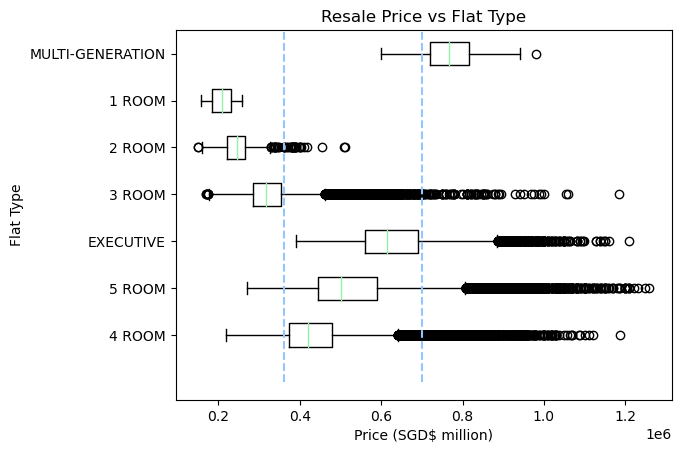

In [1685]:
flat_type_list = []
for x in data['flat_type'].unique():
    price = data[data['flat_type'] == x]['resale_price'].to_list()
    flat_type_list.append(price)
plt.boxplot(flat_type_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['flat_type'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Flat Type')
plt.vlines(360000, ymin = 0, ymax=7.5, linestyles='dashed')
plt.vlines(700000, ymin = 0, ymax=7.5, linestyles='dashed')
plt.title('Resale Price vs Flat Type')

In [1686]:
low_flat_type = ['1 ROOM', '2 ROOM', '3 ROOM']
mid_flat_type = ['EXECUTIVE', '5 ROOM', '4 ROOM']
high_flat_type = ['MULTI-GENERATION']

In [1687]:
data['flat_type'] = data['flat_type'].replace(low_flat_type, 'low')
data['flat_type'] = data['flat_type'].replace(mid_flat_type, 'mid')
data['flat_type'] = data['flat_type'].replace(high_flat_type, 'high')

In [1688]:
data.pivot_table(index = 'flat_model', values= 'resale_price', aggfunc=(np.mean, np.median, np.std)).sort_values(by='median')

,mean,median,std
flat_model,,,
2-room,2.480000e+05,245000.0,20314.198647
Standard,4.100967e+05,328000.0,187582.564942
New Generation,3.537303e+05,340294.0,71571.443032
Simplified,3.584418e+05,350000.0,69226.186410
Model A2,3.691446e+05,365000.0,44060.981144
Model A,4.361745e+05,413000.0,118614.847328
Improved,4.615346e+05,450000.0,143143.876865
Premium Apartment,4.790471e+05,468000.0,93527.902341
Apartment,6.203250e+05,605000.0,98513.733721


Text(0.5, 1.0, 'Resale Price vs Flat Model')

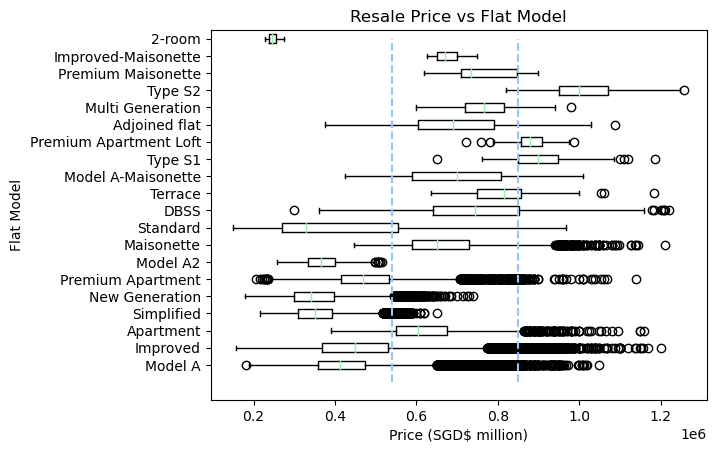

In [1689]:
flat_model_list = []
for x in data['flat_model'].unique():
    price = data[data['flat_model'] == x]['resale_price'].to_list()
    flat_model_list.append(price)
plt.boxplot(flat_model_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['flat_model'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Flat Model')
plt.vlines(540000, ymin = 0, ymax=20, linestyles='dashed')
plt.vlines(850000, ymin = 0, ymax=20, linestyles='dashed')
plt.title('Resale Price vs Flat Model')

In [1690]:
#Doing ordinal encoding for flat_model
low_flat_model = ['2-room', 'Standard', 'Model A2', 'Premium Apartment', 'New Generation', 'Simplified', 'Improved', 'Model A']
high_flat_model = ['Type S2', 'Premium Apartment Loft', 'Type S1']
mid_flat_model = [x for x in data['flat_model'].unique().tolist() if x not in (low_flat_model + high_flat_model)]

In [1691]:
mid_flat_model

['Apartment',
 'Maisonette',
 'DBSS',
 'Terrace',
 'Model A-Maisonette',
 'Adjoined flat',
 'Multi Generation',
 'Premium Maisonette',
 'Improved-Maisonette']

In [1692]:
data['flat_model'] = data['flat_model'].replace(low_flat_model, 'low')
data['flat_model'] = data['flat_model'].replace(mid_flat_model, 'mid')
data['flat_model'] = data['flat_model'].replace(high_flat_model, 'high')

In [1693]:
data['flat_model'].unique()

array(['low', 'mid', 'high'], dtype=object)

Text(0.5, 1.0, 'Resale Price vs Planning Area')

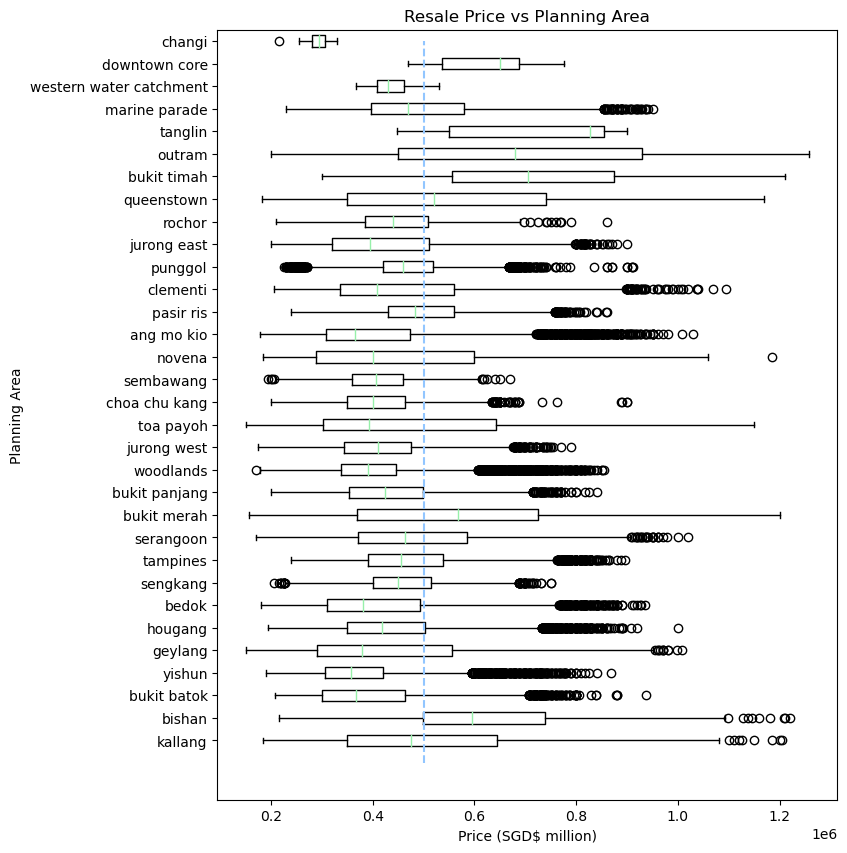

In [1694]:
planning_area_list = []
for x in data['planning_area'].unique():
    price = data[data['planning_area'] == x]['resale_price'].to_list()
    planning_area_list.append(price)
plt.figure(figsize=(8,10))
plt.boxplot(planning_area_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['planning_area'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Planning Area')
#plt.vlines(360000, ymin = 0, ymax=32, linestyles='dashed')
plt.vlines(500000, ymin = 0, ymax=32, linestyles='dashed')
plt.title('Resale Price vs Planning Area')

In [1695]:
data['planning_area'].unique()

array(['kallang', 'bishan', 'bukit batok', 'yishun', 'geylang', 'hougang',
       'bedok', 'sengkang', 'tampines', 'serangoon', 'bukit merah',
       'bukit panjang', 'woodlands', 'jurong west', 'toa payoh',
       'choa chu kang', 'sembawang', 'novena', 'ang mo kio', 'pasir ris',
       'clementi', 'punggol', 'jurong east', 'rochor', 'queenstown',
       'bukit timah', 'outram', 'tanglin', 'marine parade',
       'western water catchment', 'downtown core', 'changi'], dtype=object)

In [1696]:
low_area = ['changi', 'western water catchment', 'rochor', 'jurong east', 'punggol', 'clementi', 'ang mo kio',
            'choa chu kang', 'sembawang', 'bukit panjang', 'woodlands', 'jurong west', 'bukit batok', 'yishun', 'geylang', 
            'hougang', 'bedok', 'sengkang']
mid_area = ['marine parade', 'queenstown', 'pasir ris', 'novena', 'toa payoh', 'tampines', 'serangoon', 'bukit merah', 'kallang']
high_area = ['downtown core', 'tanglin', 'outram', 'bukit timah', 'bishan']

In [1697]:
data['planning_area'] = data['planning_area'].replace(low_area, 'low')
data['planning_area'] = data['planning_area'].replace(mid_area, 'mid')
data['planning_area'] = data['planning_area'].replace(high_area, 'high')

In [1698]:
def calculate_quantiles(x):
    return pd.Series([x.quantile(0.25), x.quantile(0.5), x.quantile(0.75)], index=['Q1', 'Q2', 'Q3'])

mrt_df = data.groupby('mrt_name')['resale_price'].apply(calculate_quantiles).unstack()

In [1699]:
mrt_df[mrt_df['Q3']<500000]

,Q1,Q2,Q3
mrt_name,,,
Admiralty,358000.0,400000.0,440000.0
Bedok,315000.0,370500.0,488000.0
Bedok North,290000.0,330000.0,420200.0
Boon Lay,376000.0,435000.0,497000.0
Braddell,285000.0,343000.0,460000.0
Bukit Batok,297000.0,380000.0,490000.0
Bukit Gombak,304000.0,360000.0,440000.0
Bukit Panjang,353000.0,425000.0,498000.0
Canberra,290000.0,320000.0,373000.0


In [1700]:
mrt_df[mrt_df['Q1']>500000]

,Q1,Q2,Q3
mrt_name,,,
Beauty World,675000.0,777500.0,915000.0
Bendemeer,833000.0,840000.0,894000.0
Bishan,510000.0,600000.0,767333.0
Bras Basah,650000.0,655000.0,707000.0
Caldecott,760000.0,828888.0,930000.0
Labrador Park,572500.0,645000.0,684000.0
Novena,534500.0,540000.0,550000.0
Outram Park,545000.0,760000.0,920000.0
Tan Kah Kee,543250.0,555000.0,579166.0


In [1701]:
low_mrt = mrt_df[mrt_df['Q3']<500000].index.tolist()
high_mrt = mrt_df[mrt_df['Q1']>500000].index.tolist()
not_classified = [x for x in data['mrt_name'].unique() if x not in (low_mrt + high_mrt)]

In [1702]:
not_classified

['Kallang',
 'Kovan',
 'Marymount',
 'Sengkang',
 'Buangkok',
 'Tampines',
 'Tiong Bahru',
 'Toa Payoh',
 'Geylang Bahru',
 'Ang Mo Kio',
 'Telok Blangah',
 'Tampines East',
 'Potong Pasir',
 'Tampines West',
 'Eunos',
 'Farrer Park',
 'Clementi',
 'Punggol',
 'Jurong East',
 'Kembangan',
 'Pasir Ris',
 'Jalan Besar',
 'Buona Vista',
 'Kaki Bukit',
 'Boon Keng',
 'Woodlands',
 'Simei',
 'Dakota',
 'Redhill',
 'Commonwealth',
 'Lorong Chuan',
 'Bedok Reservoir',
 'Holland Village',
 'HarbourFront',
 'Dover',
 'Queenstown',
 'one-north',
 'Mountbatten',
 'Serangoon',
 'Farrer Road',
 'Lavender',
 'Aljunied',
 'Little India',
 'Upper Changi',
 'Bartley',
 'Paya Lebar',
 'Tanjong Pagar',
 'Woodleigh',
 'Hillview',
 'Bencoolen',
 'Bugis',
 'Botanic Gardens']

In [1703]:
mrt_df.loc[high_mrt]

,Q1,Q2,Q3
mrt_name,,,
Beauty World,675000.0,777500.0,915000.0
Bendemeer,833000.0,840000.0,894000.0
Bishan,510000.0,600000.0,767333.0
Bras Basah,650000.0,655000.0,707000.0
Caldecott,760000.0,828888.0,930000.0
Labrador Park,572500.0,645000.0,684000.0
Novena,534500.0,540000.0,550000.0
Outram Park,545000.0,760000.0,920000.0
Tan Kah Kee,543250.0,555000.0,579166.0


In [1704]:
mrt_df.loc[low_mrt]

,Q1,Q2,Q3
mrt_name,,,
Admiralty,358000.0,400000.0,440000.0
Bedok,315000.0,370500.0,488000.0
Bedok North,290000.0,330000.0,420200.0
Boon Lay,376000.0,435000.0,497000.0
Braddell,285000.0,343000.0,460000.0
Bukit Batok,297000.0,380000.0,490000.0
Bukit Gombak,304000.0,360000.0,440000.0
Bukit Panjang,353000.0,425000.0,498000.0
Canberra,290000.0,320000.0,373000.0


In [1705]:
data['mrt_name'] = data['mrt_name'].replace(low_mrt, 'low')
data['mrt_name'] = data['mrt_name'].replace(not_classified, 'nil')
data['mrt_name'] = data['mrt_name'].replace(high_mrt, 'high')

In [1706]:
pri_sch_df = data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()

In [1707]:
pri_sch_df[pri_sch_df['Q3'] < 450000]

,Q1,Q2,Q3
pri_sch_name,,,
Ahmad Ibrahim Primary School,280000.00,313500.0,360000.0
Ang Mo Kio Primary School,305000.00,355000.0,428000.0
CHIJ,280000.00,340000.0,409500.0
CHIJ Saint Nicholas Girls' School,282000.00,335000.0,396972.0
Canossa Catholic Primary School,238444.00,271000.0,309000.0
Chongfu School,290000.00,320000.0,365750.0
Concord Primary School,340000.00,385000.0,435000.0
Corporation Primary School,342000.00,390000.0,430000.0
Damai Primary School,290000.00,336000.0,438888.0


In [1708]:
pri_sch_df[(pri_sch_df['Q1'] > 450000)]

,Q1,Q2,Q3
pri_sch_name,,,
Cantonment Primary School,480000.0,716500.0,891000.0
Catholic High School,540000.0,615000.0,800000.0
Changkat Primary School,480000.0,535000.0,617250.0
Elias Park Primary School,486500.0,540000.0,644166.0
Gan Eng Seng Primary School,530000.0,680000.0,795000.0
Kuo Chuan Presbyterian Primary School,500000.0,675000.0,760000.0
Pei Hwa Presbyterian Primary School,675000.0,777500.0,915000.0
Punggol Cove Primary School,468000.0,507500.0,549500.0
Saint Joseph's Institution Junior,580000.0,611000.0,634000.0


In [1709]:
low_pri = pri_sch_df[pri_sch_df['Q3'] < 450000].index.tolist()
high_pri = pri_sch_df[(pri_sch_df['Q1'] > 450000)].index.tolist()
not_classed_pri = [x for x in data['pri_sch_name'].unique() if x not in (low_pri + high_pri)]

In [1710]:
data['pri_sch_name'] = data['pri_sch_name'].replace(low_pri, 'low')
data['pri_sch_name'] = data['pri_sch_name'].replace(not_classed_pri, 'nil')
data['pri_sch_name'] = data['pri_sch_name'].replace(high_pri, 'high')

In [1711]:
stop running

SyntaxError: invalid syntax (2467127375.py, line 1)

In [1712]:
encoded_data = pd.get_dummies(data, columns=['1room_sold', 'mrt_interchange', 'pri_sch_affiliation', 'planning_area', 'flat_model', 'flat_type', 'multistorey_carpark', 'commercial', 'market_hawker', 'mrt_name', 'pri_sch_name'], drop_first=True)

In [1713]:
encoded_data

,floor_area_sqm,resale_price,tranc_year,tranc_month,lower,upper,mid,hdb_age,max_floor_lvl,total_dwelling_units,...,flat_model_mid,flat_type_low,flat_type_mid,multistorey_carpark_Y,commercial_Y,market_hawker_Y,mrt_name_low,mrt_name_nil,pri_sch_name_low,pri_sch_name_nil
0,90.0,680000.0,2016,5,10,12,11,15,25,142,...,0,0,1,0,0,0,0,1,0,1
1,130.0,665000.0,2012,7,7,9,8,34,9,112,...,0,0,1,0,0,0,0,0,0,0
2,144.0,838000.0,2013,7,13,15,14,24,16,90,...,1,0,1,0,0,0,1,0,0,1
3,103.0,550000.0,2012,4,1,5,3,29,11,75,...,0,0,1,0,1,0,0,0,0,0
4,83.0,298000.0,2017,12,1,3,2,34,4,48,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,625000.0,2020,9,4,6,5,26,12,60,...,1,0,1,0,1,0,0,1,1,0
150630,110.0,455000.0,2017,6,4,6,5,20,16,90,...,0,0,1,0,0,0,1,0,0,1
150631,144.0,733000.0,2020,12,10,12,11,28,15,56,...,1,0,1,0,0,0,0,1,0,1
150632,59.0,338000.0,2016,5,7,9,8,47,10,209,...,0,1,0,0,0,0,0,1,0,1


In [ ]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 52 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   floor_area_sqm             150634 non-null  float64
 1   resale_price               150634 non-null  float64
 2   tranc_year                 150634 non-null  int64  
 3   tranc_month                150634 non-null  int64  
 4   lower                      150634 non-null  int64  
 5   upper                      150634 non-null  int64  
 6   mid                        150634 non-null  int64  
 7   hdb_age                    150634 non-null  int64  
 8   max_floor_lvl              150634 non-null  int64  
 9   total_dwelling_units       150634 non-null  int64  
 10  2room_sold                 150634 non-null  int64  
 11  3room_sold                 150634 non-null  int64  
 12  4room_sold                 150634 non-null  int64  
 13  5room_sold                 15

In [1714]:
X = encoded_data[encoded_data.select_dtypes(include=('int64', 'float64', 'uint8')).columns].drop('resale_price', axis = 1)
y = data['resale_price']

In [1715]:
model = LinearRegression()

# Create the RFE object with the linear regression model and desired number of features to select
rfe = RFE(estimator=model, n_features_to_select=30)

# Perform RFE on the dataset
X_selected = rfe.fit_transform(X, y)

# Get the selected feature indices
# selected_indices = rfe.get_support(indices=True)
#X.columns[rfe.get_support(indices=True)]

In [1716]:
X.columns[rfe.get_support(indices=True)].tolist()

['floor_area_sqm',
 'tranc_year',
 'lower',
 'upper',
 'mid',
 'hdb_age',
 'max_floor_lvl',
 'other_room_rental',
 'mall_within_500m',
 'mall_within_1km',
 'mall_within_2km',
 'hawker_within_500m',
 'hawker_within_1km',
 'hawker_within_2km',
 '1room_sold_255',
 'mrt_interchange_1',
 'pri_sch_affiliation_1',
 'planning_area_low',
 'planning_area_mid',
 'flat_model_low',
 'flat_model_mid',
 'flat_type_low',
 'flat_type_mid',
 'multistorey_carpark_Y',
 'commercial_Y',
 'market_hawker_Y',
 'mrt_name_low',
 'mrt_name_nil',
 'pri_sch_name_low',
 'pri_sch_name_nil']

In [ ]:
encoded_data[X.columns[rfe.get_support(indices=True)].tolist()]

,floor_area_sqm,tranc_year,tranc_month,lower,upper,mid,hdb_age,max_floor_lvl,total_dwelling_units,studio_apartment_sold,...,pri_sch_affiliation_1,planning_area_low,planning_area_mid,flat_model_low,flat_model_mid,flat_type_low,flat_type_mid,multistorey_carpark_Y,commercial_Y,market_hawker_Y
0,90.0,2016,5,10,12,11,15,25,142,0,...,1,0,1,1,0,0,1,0,0,0
1,130.0,2012,7,7,9,8,34,9,112,0,...,1,0,0,1,0,0,1,0,0,0
2,144.0,2013,7,13,15,14,24,16,90,0,...,0,1,0,0,1,0,1,0,0,0
3,103.0,2012,4,1,5,3,29,11,75,0,...,1,0,0,1,0,0,1,0,1,0
4,83.0,2017,12,1,3,2,34,4,48,0,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,2020,9,4,6,5,26,12,60,0,...,0,1,0,0,1,0,1,0,1,0
150630,110.0,2017,6,4,6,5,20,16,90,0,...,0,1,0,1,0,0,1,0,0,0
150631,144.0,2020,12,10,12,11,28,15,56,0,...,1,1,0,0,1,0,1,0,0,0
150632,59.0,2016,5,7,9,8,47,10,209,0,...,0,0,1,1,0,1,0,0,0,0


In [1717]:
# Initialize SelectKBest with f_regression scoring function and select top 30 features
selector = SelectKBest(score_func=f_regression, k=30)

# Fit SelectKBest to your data
selector.fit(X, y)

# Retrieve selected features
X_selected = selector.transform(X)
selected_indices = selector.get_support(indices=True)
selected_columns = X.columns[selector.get_support()]

# print X_selected -> names of predictors
X_selected = X.iloc[:, selected_indices].columns
X_selected

Index(['floor_area_sqm', 'lower', 'upper', 'mid', 'hdb_age', 'max_floor_lvl',
       'total_dwelling_units', '2room_sold', '3room_sold', '4room_sold',
       '5room_sold', 'exec_sold', 'mall_nearest_distance', 'mall_within_500m',
       'mall_within_2km', 'hawker_within_1km', 'hawker_within_2km',
       'mrt_nearest_distance', 'sec_sch_nearest_dist', 'planning_area_low',
       'planning_area_mid', 'flat_model_low', 'flat_model_mid',
       'flat_type_low', 'flat_type_mid', 'commercial_Y', 'mrt_name_low',
       'mrt_name_nil', 'pri_sch_name_low', 'pri_sch_name_nil'],
      dtype='object')

In [ ]:
encoded_data[encoded_data.select_dtypes(include=('int64', 'float64', 'uint8')).columns.to_list()].corr()['resale_price'].sort_values()

flat_type_low               -0.539367
flat_model_low              -0.477260
3room_sold                  -0.410368
hdb_age                     -0.350337
mrt_name_low                -0.327168
planning_area_low           -0.290741
2room_sold                  -0.145287
total_dwelling_units        -0.140725
commercial_Y                -0.140183
mrt_nearest_distance        -0.128222
mall_nearest_distance       -0.092239
3room_rental                -0.079965
2room_rental                -0.077548
1room_sold_255              -0.039434
1room_rental                -0.037993
hawker_food_stalls          -0.033581
tranc_year                  -0.019146
vacancy                     -0.016140
hawker_nearest_distance     -0.014537
pri_sch_nearest_distance    -0.011004
hawker_market_stalls        -0.009378
multistorey_carpark_Y       -0.007799
tranc_month                 -0.006823
market_hawker_Y             -0.005940
hawker_within_500m           0.012637
other_room_rental            0.013049
pri_sch_affi

In [1731]:
selected_col = ['floor_area_sqm', 'lower', 'upper', 'mid', 'hdb_age', 'max_floor_lvl',
       'total_dwelling_units', '2room_sold', '3room_sold', '4room_sold',
       '5room_sold', 'exec_sold', 'mall_nearest_distance', 'mall_within_500m',
       'mall_within_2km', 'hawker_within_1km', 'hawker_within_2km',
       'mrt_nearest_distance', 'sec_sch_nearest_dist', 'planning_area_low',
       'planning_area_mid', 'flat_model_low', 'flat_model_mid',
       'flat_type_low', 'flat_type_mid', 'commercial_Y', 'mrt_name_low',
       'mrt_name_nil', 'pri_sch_name_low', 'pri_sch_name_nil']

In [1732]:
X = encoded_data[selected_col]

In [1733]:
X

,floor_area_sqm,lower,upper,mid,hdb_age,max_floor_lvl,total_dwelling_units,2room_sold,3room_sold,4room_sold,...,planning_area_mid,flat_model_low,flat_model_mid,flat_type_low,flat_type_mid,commercial_Y,mrt_name_low,mrt_name_nil,pri_sch_name_low,pri_sch_name_nil
0,90.0,10,12,11,15,25,142,0,0,96,...,1,1,0,0,1,0,0,1,0,1
1,130.0,7,9,8,34,9,112,0,0,56,...,0,1,0,0,1,0,0,0,0,0
2,144.0,13,15,14,24,16,90,0,0,0,...,0,0,1,0,1,0,1,0,0,1
3,103.0,1,5,3,29,11,75,0,0,68,...,0,1,0,0,1,1,0,0,0,0
4,83.0,1,3,2,34,4,48,0,0,30,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,4,6,5,26,12,60,0,6,4,...,0,0,1,0,1,1,0,1,1,0
150630,110.0,4,6,5,20,16,90,0,0,30,...,0,1,0,0,1,0,1,0,0,1
150631,144.0,10,12,11,28,15,56,0,0,0,...,0,0,1,0,1,0,0,1,0,1
150632,59.0,7,9,8,47,10,209,0,200,0,...,1,1,0,1,0,0,0,1,0,1


---------------------

In [1734]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

In [1735]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)
print('Linear Regression score:',lr.score(X_train,y_train))
lrpred=lr.predict(X_test)
print('Mean Squared Error: ',mean_squared_error(y_test,lrpred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,lrpred))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,lrpred)))
print('Test Score: ',lr.score(X_test, y_test))

276711.28421477776
[ 3.32246900e+03 -8.86448186e+03  1.11425248e+04  1.13902146e+03
 -2.12500463e+03  4.70681181e+03 -9.19415509e+01 -3.72757413e+02
 -9.26929759e+01  1.31719829e+01 -8.11480102e+01 -5.74781111e+02
  6.90591419e+00  6.86702826e+03 -1.17831505e+03  5.73349055e+03
  7.90479446e+03 -4.50028508e+01  1.10739837e+01 -7.82482968e+04
 -5.30795419e+04 -4.69122010e+04  5.39883614e+04 -4.09510707e+04
 -3.97931352e+04 -5.51959263e+03 -5.47009784e+04 -2.20290089e+04
 -2.19072296e+04 -1.36865888e+04]
Linear Regression score: 0.8224713542290982
Mean Squared Error:  3628849814.068798
Mean Absolute Error:  46096.542940522544
Root Mean Squared Error:  60239.93537570237
Test Score:  0.8232917310754746


In [1723]:
print("R2 Score:", r2_score(y_test, lrpred))
print("Train Score:", lr.score(X_train, y_train))
print("Test Score:", lr.score(X_test, y_test))
print("Cross Validation Score:", cross_val_score(lr, X_train, y_train, cv=20).mean())

R2 Score: 0.8232917310754746
Train Score: 0.8224713542290982
Test Score: 0.8232917310754746
Cross Validation Score: 0.8222726652723505


In [1724]:
ridgeRegressor = Ridge()
ridgeRegressor.fit(X_train, y_train)
ridge_pred = ridgeRegressor.predict(X_test)

# Calculate model performance
# To derive other metrics, check out https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
R_squared = r2_score(ridge_pred, y_test)
print('Test R-squared score :', R_squared)

Test R-squared score : 0.7858029852060804


In [1725]:
lassoRegressor = Lasso()
lassoRegressor.fit(X_train, y_train)
lasso_pred = lassoRegressor.predict(X_test)

# Calculate model performance
# To derive other metrics, check out https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
R_squared = r2_score(lasso_pred, y_test)
print('Test R-squared score :', R_squared)

Test R-squared score : 0.7857763766404514


-----------------------------

In [ ]:
test = pd.read_csv('datasets/test.csv')

In [ ]:
#standardizing all column names to be in snake case
test.columns = test.columns.str.lower().str.replace(' ','_')

In [ ]:
test['planning_area'] = test['planning_area'].str.lower()

In [ ]:
test.isnull().sum().sort_values()

id                        0
1room_rental              0
sec_sch_latitude          0
3room_rental              0
other_room_rental         0
                      ...  
mall_within_1km        2786
hawker_within_2km      3254
hawker_within_1km      6729
mall_within_500m      10292
hawker_within_500m    10755
Length: 77, dtype: int64

In [ ]:
col_with_null = test.columns[test.isnull().sum() != 0].to_list()

In [ ]:
imputer=SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
for x in col_with_null:
    test[x]=imputer.fit_transform(test[x].values.reshape(-1,1))

In [ ]:
test['flat_type'] = test['flat_type'].replace(low_flat_type, 'low')
test['flat_type'] = test['flat_type'].replace(mid_flat_type, 'mid')
test['flat_type'] = test['flat_type'].replace(high_flat_type, 'high')

test['flat_model'] = test['flat_model'].replace(low_flat_model, 'low')
test['flat_model'] = test['flat_model'].replace(high_flat_model, 'high')

test['planning_area'] = test['planning_area'].replace(low_area, 'low')
test['planning_area'] = test['planning_area'].replace(mid_area, 'mid')
test['planning_area'] = test['planning_area'].replace(high_area, 'high')

In [ ]:
encoded_test = pd.get_dummies(test, columns=['planning_area', 'flat_model', 'flat_type', 'multistorey_carpark', 'commercial', 'market_hawker'], drop_first=True)

In [ ]:
encoded_test[selected_col]

,floor_area_sqm,3room_sold,hdb_age,max_floor_lvl,5room_sold,upper,mid,lower,exec_sold,planning_area_low,...,hawker_within_2km,mall_within_2km,sec_sch_nearest_dist,4room_sold,hawker_within_1km,mall_nearest_distance,3room_rental,2room_rental,mall_within_500m,mall_within_1km
0,84.0,0,34,12,40,9,8,7,0,1,...,1.0,4.0,156.322353,92,1.0,877.431572,0,0,0.0,2.0
1,112.0,0,13,14,25,6,5,4,0,1,...,0.0,3.0,739.371688,28,0.0,534.037705,0,0,0.0,1.0
2,68.0,191,41,12,1,9,8,7,1,1,...,11.0,3.0,305.071191,22,3.0,817.050453,3,0,0.0,2.0
3,97.0,0,42,14,0,3,2,1,0,1,...,2.0,3.0,433.454591,104,1.0,1272.737194,0,0,0.0,0.0
4,103.0,0,36,25,96,18,17,16,0,1,...,2.0,5.0,217.295361,48,2.0,1070.963675,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16732,82.0,196,41,11,2,6,5,4,0,1,...,8.0,2.0,320.543569,60,2.0,1120.535819,0,0,0.0,0.0
16733,92.0,14,9,16,2,18,17,16,0,1,...,0.0,5.0,423.996711,64,0.0,519.046576,0,0,0.0,2.0
16734,110.0,0,19,16,90,6,5,4,0,1,...,0.0,3.0,560.399339,30,0.0,685.922630,0,0,0.0,2.0
16735,84.0,0,33,9,40,9,8,7,0,0,...,7.0,3.0,324.050692,64,1.0,846.849200,0,0,0.0,1.0


In [ ]:
lrpred=lr.predict(encoded_test[selected_col])

In [ ]:
test_lr_export = test['id'].to_frame()

In [ ]:
test_lr_export['Predicted'] = lrpred

In [ ]:
test_lr_export.to_csv('kag.csv')

In [ ]:
ridge_pred = ridgeRegressor.predict(encoded_test[selected_col])

In [ ]:
test_ridge_export = test['id'].to_frame()
test_ridge_export['Predicted'] = ridge_pred

In [ ]:
test_ridge_export.to_csv('kag_ridge.csv')

In [ ]:
lasso_pred = lassoRegressor.predict(encoded_test[selected_col])

In [ ]:
test_lasso_export = test['id'].to_frame()
test_lasso_export['Predicted'] = lasso_pred

In [ ]:
test_lasso_export.to_csv('kag_lasso.csv')